In [2]:
import requests 
import json
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import pickle
from selenium import webdriver
from selenium.webdriver.support.ui import Select
from selenium.common.exceptions import NoSuchElementException, UnexpectedAlertPresentException
from gensim.models import Word2Vec
import statsmodels.api as sm
from statsmodels.graphics import utils
from sklearn.cross_validation import cross_val_score, cross_val_predict, ShuffleSplit, StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import nltk
from nltk.tokenize import sent_tokenize
from gensim.summarization import summarize
import mykmeans as kmeans
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import copy

In [77]:
from selenium import webdriver
from selenium.webdriver.support.ui import Select
from selenium.common.exceptions import NoSuchElementException, UnexpectedAlertPresentException
from time import sleep
from bs4 import BeautifulSoup
import requests 
import pickle
from requests.exceptions import ConnectionError
from gensim.models import Word2Vec
import mykmeans as kmeans
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import copy

In [ ]:
def replacer(s):
    s = s.replace('\n', '').replace('\r', '').replace('\t', '')
    return s

In [ ]:
def save(df, name):
    df.to_excel(name + ".xlsx")
    f = open(name + "_pickle.txt", 'w')
    pickle.dump(df, f)
    f.close()

In [ ]:
BASE_URL = "http://store.steampowered.com"
CHART_BASE_URL = "http://steamcharts.com"

In [ ]:
# 스팀차트에서 게임 리스트 크롤링
game_df = pd.DataFrame(columns=['name', 'link'])

for i in range(1, 10):
    steamchart_url = CHART_BASE_URL + "/top/p.{page_num}".format(page_num=i)
    response = requests.get(steamchart_url)
    dom = BeautifulSoup(response.content, 'html.parser')
    top_games_table = dom.select("table#top-games td.game-name.left")
    for top_game in top_games_table:
        name = replacer(top_game.select_one('a').text)
        link = top_game.select_one('a').attrs.get('href')
        game_df.loc[len(game_df)] = [name, link]

In [ ]:
save(game_df, "game_df_old")

In [2]:
f = open("game_df_pickle.txt")
game_df = pickle.load(f)
f.close()

In [3]:
#steamchart 평균 플레이어수 기준 상위 200개 게임에서 작성한 리뷰를 최대 100페이지까지 확인,
#리뷰를 쓴 유저 중에 겹치지 않고, 보유 게임 리스트를 공개한 유저의 게임 링크 정보 크롤링
reviewer_link_list = []

for i, row in game_df.iterrows():
    for i in range(1, 100):
        steam_review_url = ("http://steamcommunity.com{game_df_link}"
                            "/homecontent/?userreviewsoffset={offset_num}&p={page_num}"
                            "&appHubSubSection=10&browsefilter=toprated&filterLanguage=english&searchText="
                           ).format(game_df_link=row["link"], offset_num=10*(i-1), page_num=i)
        try:
            response = requests.get(steam_review_url)
        except ConnectionError:
            sleep(10)
            response = requests.get(steam_review_url)
        dom = BeautifulSoup(response.content, 'html.parser')
        reviewer_link_table = dom.select("div.apphub_friend_block_container")
        for reviewer_link in reviewer_link_table:
            link = reviewer_link.select_one('a').attrs.get('href')
            if(link != u''):
                if(link not in reviewer_link):
                    reviewer_link_list.append(link)

In [4]:
len(reviewer_link_list)

191096

In [5]:
f = open("reviewer_link_list_pickle.txt", 'w')
pickle.dump(reviewer_link_list, f)
f.close()

In [3]:
f = open("reviewer_link_list_pickle.txt")
reviewer_link_list = pickle.load(f)
f.close()

In [6]:
#리뷰어의 보유 게임 리스트 링크를 바탕으로 보유 게임을 최대 20개까지 크롤링
#중간에 오류가 발견됨, 그러나 이틀동안 43000명의 보유 게임 리스트를 받은 관계로 잠시 보류
driver = webdriver.PhantomJS()

owner_list = []
i = 0

for link in reviewer_link_list:
    try:
        driver.get(link + "games/?tab=all")
        game_elements = driver.find_elements_by_css_selector("div#games_list_rows div.gameListRowItemName.ellipsis ")
        one_owner_list = []
        if(len(game_elements) > 20):
            for game_element in game_elements[:20]:
                game = game_element.text
                one_owner_list.append(game)
            owner_list.append(one_owner_list)
            i += 1
            if(i % 1000 == 0):
                print(one_owner_list)
                f = open("owner_list_big_pickle.txt", 'w')
                pickle.dump(owner_list, f)
                f.close()
    except UnexpectedAlertPresentException:
        pass
driver.quit()  

[u"Garry's Mod", u'planetarian ~the reverie of a little planet~', u'Universe Sandbox', u'Grand Theft Auto', u'CameraBag 2', u'Zoom Player Steam Edition', u'Geekbench 3', u'Narcissu 1st & 2nd', u'Quake III Arena', u'Quake II', u'Quake', u'Quake II: The Reckoning', u'Quake III: Team Arena', u'Quake Mission Pack 2: Dissolution of Eternity', u'Quake Mission Pack 1: Scourge of Armagon', u'Quake II: Ground Zero', u"Five Nights at Freddy's", u"Five Nights at Freddy's 2", u"Five Nights at Freddy's 3", u'Quake Live']
[u'Team Fortress 2', u'Counter-Strike: Source', u"Garry's Mod", u'PAYDAY 2', u'Counter-Strike: Global Offensive', u'Warframe', u'Borderlands 2', u'Evolve', u'Insurgency', u'Borderlands: The Pre-Sequel', u'Left 4 Dead 2', u'Source Filmmaker', u"Tom Clancy's Rainbow Six Siege", u'Terraria', u'Rocket League', u'Killing Floor 2', u'Trove', u'Dragon Nest Europe', u'Dungeon Defenders II', u"Don't Starve Together Beta"]
[u"Sid Meier's Civilization V", u'Prison Architect', u'Port Royale 3'

Exception WindowsError: WindowsError(32, '') in <bound method Service.__del__ of <selenium.webdriver.phantomjs.service.Service object at 0x0000000008B3AC18>> ignored


WebDriverException: Message: {"request":{"headers":{"Accept":"application/json","Accept-Encoding":"identity","Connection":"close","Content-Length":"144","Content-Type":"application/json;charset=UTF-8","Host":"127.0.0.1:4011","User-Agent":"Python-urllib/2.7"},"httpVersion":"1.1","method":"POST","post":"{\"using\": \"css selector\", \"sessionId\": \"b3542720-f353-11e5-bc83-a9290a0aba91\", \"value\": \"div#games_list_rows div.gameListRowItemName.ellipsis \"}","url":"/elements","urlParsed":{"anchor":"","query":"","file":"elements","directory":"/","path":"/elements","relative":"/elements","port":"","host":"","password":"","user":"","userInfo":"","authority":"","protocol":"","source":"/elements","queryKey":{},"chunks":["elements"]},"urlOriginal":"/session/b3542720-f353-11e5-bc83-a9290a0aba91/elements"}}
Screenshot: available via screen


In [7]:
len(owner_list_big)

43581

In [2]:
f = open("owner_list_big_pickle.txt")
owner_list_big = pickle.load(f)
f.close()

In [15]:
owner_list_big[0]

[u"Garry's Mod",
 u'Dota 2',
 u"Sid Meier's Civilization V",
 u'Total War: SHOGUN 2',
 u'Crusader Kings II',
 u'Europa Universalis IV',
 u'Kerbal Space Program',
 u'The Elder Scrolls V: Skyrim',
 u'Arma 3',
 u'Counter-Strike: Global Offensive',
 u'Fallout 4',
 u'Fallout: New Vegas',
 u'Mount & Blade: Warband',
 u'Terraria',
 u'Total War: ATTILA',
 u'Rising Storm/Red Orchestra 2 Multiplayer',
 u'The Witcher 3: Wild Hunt',
 u'METAL GEAR SOLID V: THE PHANTOM PAIN',
 u'Cities: Skylines',
 u'XCOM 2']

In [3]:
model2 = Word2Vec(owner_list_big, window=5, min_count=0, sg=1, size=256, batch_words=700)

In [5]:
model2.save("game2vec_model")

In [6]:
model2 = Word2Vec.load("game2vec_model")

In [7]:
len(model2.syn0)

5542

In [6]:
model2.most_similar(positive=[u'Football Manager 2015'], topn=10)

[(u'Football Manager 2013', 0.9216866493225098),
 (u'Football Manager 2016', 0.9177965521812439),
 (u'Football Manager 2014', 0.9145956039428711),
 (u'Football Manager 2012', 0.9056244492530823),
 (u'Football Manager 2013 Russian', 0.8936604857444763),
 (u'Football Manager 2009', 0.8929958343505859),
 (u'Football Manager 2011', 0.8868577480316162),
 (u'Football Manager 2010', 0.8819534182548523),
 (u'Out of the Park Baseball 16', 0.8422746062278748),
 (u'NBA 2K13', 0.8183190822601318)]

In [8]:
model2.most_similar(positive=[u"Dota 2",], topn=10)

[(u'League of Legends', 0.7461559176445007),
 (u'ShootMania Storm', 0.7292128801345825),
 (u'MorphVOX Pro - Voice Changer', 0.7146892547607422),
 (u'MAGIX Music Maker 2014', 0.689863920211792),
 (u'SMITE', 0.6866061687469482),
 (u'Gotham City Impostors', 0.6822215914726257),
 (u'Black Ink', 0.6820778846740723),
 (u'Borderless Gaming', 0.6814875602722168),
 (u'Forsaken World', 0.6798227429389954),
 (u'Substance Designer 4', 0.6755606532096863)]

In [100]:
#K-Fold Cross Validation
#K=3이며 보유 게임 리스트가 게임 플레이 시간이 많은 것에서 적은 순으로 정렬,
#게임 플레이 시간이 많은 게임 상위 3개를 기준으로 각각 5개의 유사 게임 추천,
#상위 3개의 게임을 제외한 리스트 상에서 추천한 게임과 같은 게임을 보유했을 때 score증가
index_list = np.linspace(0, len(owner_list_big)-1, num=4, dtype=int)
split_index_list = []

for i in range(0, 3):
    split_index_list.append([i,i+2])

for i in range(0, 3):
    score = 0
    split = copy.deepcopy(split_index_list)
    test = split.pop(0)
    test_index = index_list[test[0]:test[1]]
    owner_test_list = owner_list_big[test_index[0]:test_index[1]]
    total = len(owner_test_list)
    owner_train_list = []
    for split_index in split:
        train_index = index_list[split_index[0]:split_index[1]]
        owner_train_list += owner_list_big[train_index[0]:train_index[1]]
    
        model2 = Word2Vec(owner_train_list, window=5, min_count=0, sg=1, size=256, batch_words=700)
        model2.init_sims(replace=True)
        for owner_test_game in owner_test_list:
            recommending_success = False
            for most_game in owner_test_game[:3]:
                try:
                    result = model2.most_similar(positive=most_game, topn=5)
                    for tu in result:
                        if(tu[0] in owner_test_game[3:]):
                            recommending_success = True
                            break
                except KeyError:
                    pass
                if(recommending_success == True):
                    score += 1
                    break
    print('score : {score}, total : {total}, accuracy : {accuracy}'.format(score=score, total=total, accuracy=(score/total)*100))

score : 8052, total : 14333, accuracy : 56.1780506523
score : 9283, total : 14333, accuracy : 64.7666224796
score : 7445, total : 14333, accuracy : 51.9430684435


In [9]:
game_vec = model2.syn0

In [108]:
len(game_vec)

5542

In [118]:
# https://ko.wikipedia.org/wiki/K-%ED%8F%89%EA%B7%A0_%EC%95%8C%EA%B3%A0%EB%A6%AC%EC%A6%98#.ED.81.B4.EB.9F.AC.EC.8A.A4.ED.84.B0.EC.9D.98_.EC.88.98
int(round(np.sqrt(len(game_vec)/2)))

53

In [10]:
centers, index2cid, dist = kmeans.kmeanssample(game_vec, k=int(round(np.sqrt(len(game_vec)/2))), 
                                               metric='cosine', delta=0.00000001, nsample=0, maxiter=100)

kmeans: X (530L, 256L)  centres (53L, 256L)  delta=1e-08  maxiter=100  metric=cosine
('kmeans: 14 iterations  cluster sizes:', array([ 1,  1,  7,  9,  4,  3,  5, 15, 15,  5, 45,  3, 13, 17,  1, 17, 12,
        8, 13,  8, 26, 15, 10, 11, 29,  5, 17,  0,  9, 16, 11,  3, 13,  2,
       11, 15,  5,  6, 21,  0,  4, 12, 11,  4,  7,  5,  0,  1, 33,  6,  7,
       12,  1], dtype=int64))
kmeans: X (5542L, 256L)  centres (53L, 256L)  delta=1e-08  maxiter=100  metric=cosine
('kmeans: 35 iterations  cluster sizes:', array([ 64,  24,  53,  75,  28,  29,  57,  57, 116,  69, 623,  53,  47,
        87,  41,  89,  78,  48, 122,  81, 238, 114,  41, 139, 400,  24,
       106, 399,  74, 122,  87,  64, 201,  26,  53,  85,  56,  82, 240,
         1,  61,  56,  50,  36,  46,  44,  36,   2, 498,  63,  54, 125,  78], dtype=int64))


In [11]:
clustered_df = pd.DataFrame([(a, b, c) for a, b, c in zip(model2.index2word, index2cid, dist)],
                            columns=['title', 'cid', 'dist']).sort_values(['cid', 'dist'], ascending=True)

In [12]:
f = open("clustered_df_pickle.txt", 'w')
pickle.dump(clustered_df, f)
f.close()

In [ ]:
f = open("clustered_df_pickle.txt")
clustered_df = pickle.load(f)
f.close()

In [17]:
clustered_df[clustered_df.cid == 1]

,title,cid,dist
1218,NEKOPARA Vol. 2,1,0.037780
1349,eden*,1,0.057310
1412,Higurashi When They Cry - Ch.1 Onikakushi,1,0.060002
1657,Sakura Swim Club,1,0.060398
1462,Sakura Fantasy Chapter 1,1,0.064470
2565,Sakura Beach,1,0.064832
1135,Sakura Angels,1,0.074892
2309,A Kiss for the Petals - Remembering How We Met,1,0.076017
647,Sakura Spirit,1,0.078468
1159,BlazBlue: Calamity Trigger,1,0.082963


In [13]:
tsne = TSNE(n_components=3, random_state=0)
np.set_printoptions(suppress=True)

In [14]:
tsne_game_vec = tsne.fit_transform(game_vec) 

In [15]:
f = open("tsne_game_vec_pickle.txt", 'w')
pickle.dump(tsne_game_vec, f)
f.close()

In [ ]:
f = open("tsne_game_vec_pickle.txt")
tsne_game_vec = pickle.load(f)
f.close()

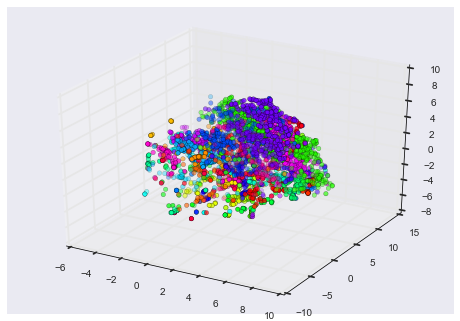

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax = fig.add_subplot(111)
colors = iter(cm.hsv(np.linspace(0, 1, 33)))
for i in range(0, 33):
    xlist = []
    ylist = []
    zlist = []
    for j in clustered_df[clustered_df.cid == i].index:
        xlist.append(tsne_game_vec[j][0])
        ylist.append(tsne_game_vec[j][1])
        zlist.append(tsne_game_vec[j][2])
    ax.scatter(xlist, ylist, zlist, c=next(colors))
plt.show()